# Uber Trip Analysis - 2014
### Objective:
- Explore and preprocess Uber trip data.
- Train and evaluate predictive models (XGBoost, GBTR, Random Forest).
- Use ensemble techniques to improve accuracy.
- Compare model performance using MAPE.

##  Data Exploration & Preprocessing
This section involves:
- Loading the dataset.
- Checking for missing values and outliers.
- Transforming the data for model training.

In [1]:
# 1. Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

In [3]:
# 2. Load the Data

In [4]:
data = pd.read_csv('C:/Users/Mangesh/Desktop/manju/Internship/UNIF/PP1/uber-raw-data-apr14.csv')

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB
None


In [6]:
## Data Preprocessing

In [7]:
print(data.columns)

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')


In [8]:
print(data.isnull().sum())  # See if any column has missing values

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64


In [9]:
print(data['Date/Time'].head(10))  # Check the first 10 rows
print(data['Date/Time'].dtype)  # See its current data type

0    04-01-2014 00:11
1    04-01-2014 00:17
2    04-01-2014 00:21
3    04-01-2014 00:28
4    04-01-2014 00:33
5    04-01-2014 00:33
6    04-01-2014 00:39
7    04-01-2014 00:45
8    04-01-2014 00:55
9    04-01-2014 01:01
Name: Date/Time, dtype: object
object


In [10]:
# Convert 'Date/Time' to datetime format
data['Date/Time'] = pd.to_datetime(data['Date/Time'], errors='coerce')

In [11]:
# Handle NaT values (invalid datetime)
print(data['Date/Time'].isna().sum())

340903


In [12]:
# Extract features from 'Date/Time'
data['Hour'] = data['Date/Time'].dt.hour
data['Day'] = data['Date/Time'].dt.day
data['DayOfWeek'] = data['Date/Time'].dt.dayofweek
data['Month'] = data['Date/Time'].dt.month
print(data[['Date/Time', 'Hour', 'Day', 'DayOfWeek', 'Month']].head())

            Date/Time  Hour  Day  DayOfWeek  Month
0 2014-04-01 00:11:00   0.0  1.0        1.0    4.0
1 2014-04-01 00:17:00   0.0  1.0        1.0    4.0
2 2014-04-01 00:21:00   0.0  1.0        1.0    4.0
3 2014-04-01 00:28:00   0.0  1.0        1.0    4.0
4 2014-04-01 00:33:00   0.0  1.0        1.0    4.0


In [13]:
#  4. Exploratory Data Analysis (EDA)

## Exploratory Data Analysis

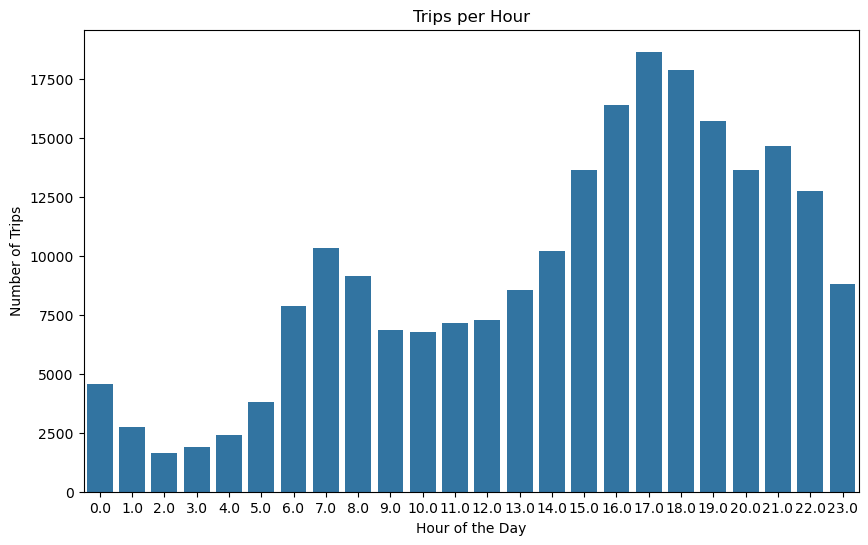

In [14]:
# Plotting the number of trips per hour
plt.figure(figsize=(10,6))
sns.countplot(x=data['Hour'])
plt.title('Trips per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()

## Conclusion:
The number of trips is relatively low during the early morning hours (midnight to around 5 AM).
A significant increase in trips occurs from 6 AM onwards, peaking between 5 PM and 6 PM, indicating high demand during evening rush hours.
There is also a smaller peak around 7 AM to 8 AM, likely corresponding to the morning commute.
After 7 PM, the number of trips starts to decline gradually but remains higher than early morning hours.
These insights suggest that Uber experiences the highest demand during peak commute times, particularly in the evening. This information can be useful for ride-hailing companies to optimize driver availability and pricing strategies.

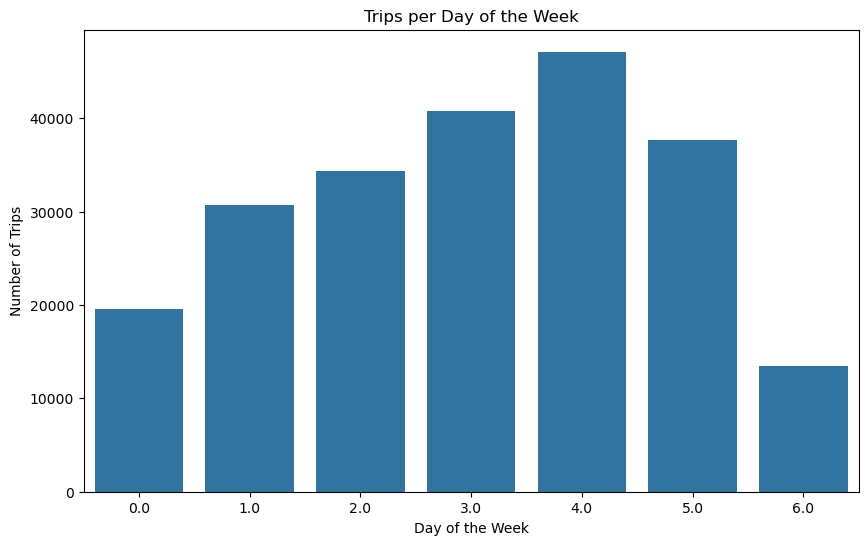

In [15]:
# Plotting the number of trips per day of the week
plt.figure(figsize=(10,6))
sns.countplot(x=data['DayOfWeek'])
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.show()

## Conclusion:
The number of trips varies across different days of the week.
The highest number of trips occurs on the 4th day (likely Thursday or Friday, depending on the dataset's indexing).
The number of trips generally increases from the start of the week, reaching a peak mid-to-late week.
After the peak, the number of trips starts to decline toward the weekend, with the lowest number observed on the last day (likely Sunday).
This trend suggests that ride demand is higher on weekdays, possibly due to work commutes and other weekday activities, and lower on weekends when people may travel less.

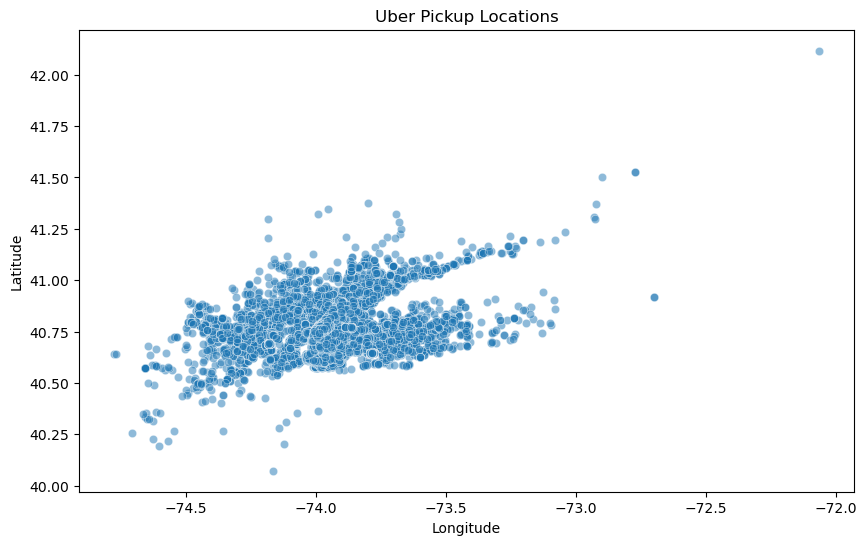

In [16]:
# Plotting Uber Pickup Locations (Latitude vs Longitude)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Lon'], y=data['Lat'], alpha=0.5)
plt.title("Uber Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Conclusion 
This scatter plot visualizes Uber pickup locations based on latitude and longitude. The dense clustering suggests that most pickups occur in a concentrated area, likely a metropolitan region such as New York City. The spread of points indicates that pickups also happen in surrounding areas, though less frequently.

In [17]:
# 5. Model Training & Preprocessing for Model Training

## Model Training
We will train the following models:
1. **XGBoost**
2. **Gradient Boosting Trees (GBTR)**
3. **Random Forest**  
Hyperparameter tuning will be performed using GridSearchCV.

In [18]:
# Grouping the data by Hour, Day, Month, DayOfWeek and calculating TripCount
data['TripCount'] = data.groupby(['Hour', 'Day', 'Month'])['Hour'].transform('count')

In [19]:
# Redefining the data frame for model training
data = data.groupby(['Hour', 'Day', 'Month', 'DayOfWeek']).size().reset_index(name='TripCount')

In [20]:
# Define features (X) and target variable (y)
X = data[['Hour', 'Day', 'Month', 'DayOfWeek']]
y = data['TripCount']

In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Step 4: Random Forest Model
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [23]:
# Evaluation
print("Random Forest - Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Random Forest - R^2 Score:", r2_score(y_test, y_pred))

Random Forest - Mean Squared Error: 17933.226646551724
Random Forest - R^2 Score: 0.9436420589492389


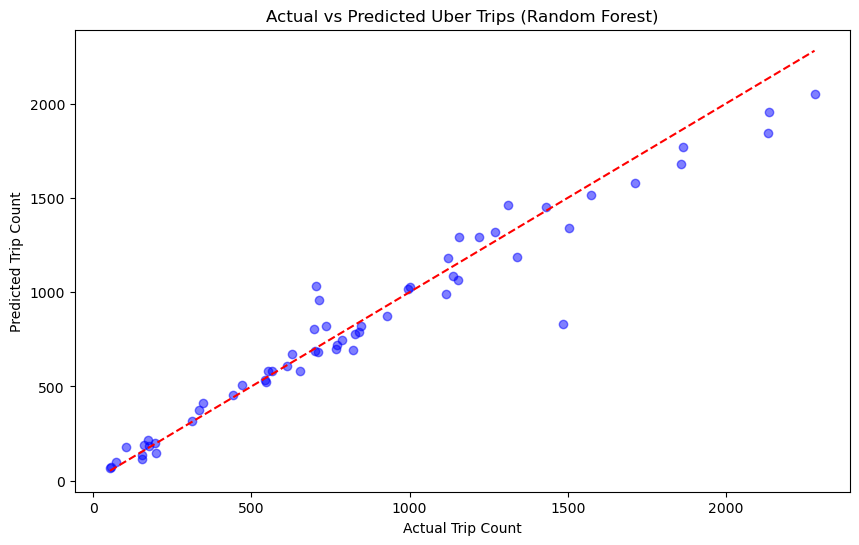

In [24]:
# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Actual vs Predicted Uber Trips (Random Forest)')
plt.show()

In [25]:
# Feature Importance
importances = rfr.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

C:\Users\Mangesh\AppData\Local\Temp\ipykernel_12172\1801592545.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


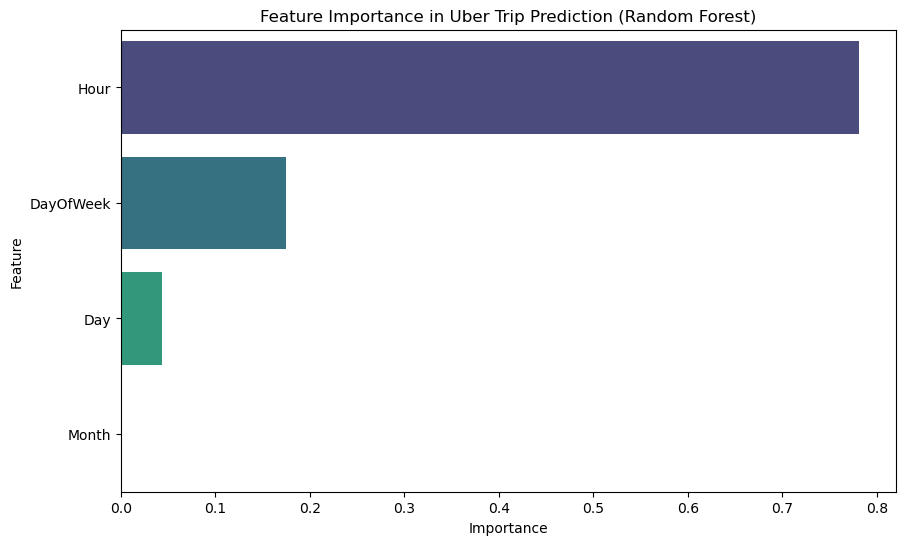

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title('Feature Importance in Uber Trip Prediction (Random Forest)')
plt.show()

In [27]:
# Step 5: XGBoost with GridSearchCV
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)
xgb_grid_search.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [28]:
y_pred_xgb = xgb_grid_search.best_estimator_.predict(X_test)
print("XGBoost - Mean Squared Error:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost - R^2 Score:", r2_score(y_test, y_pred_xgb))

XGBoost - Mean Squared Error: 11272.175810693017
XGBoost - R^2 Score: 0.9645754424246344


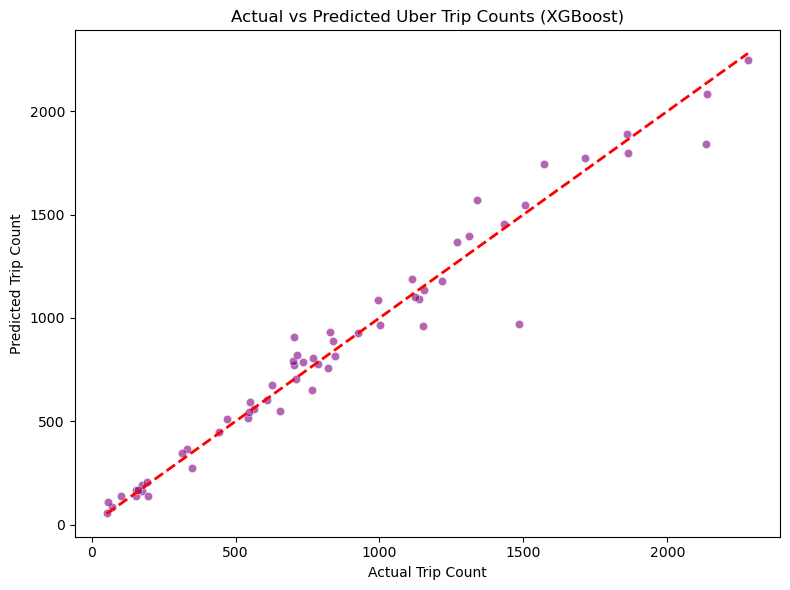

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Actual vs Predicted Uber Trip Counts (XGBoost)')
plt.tight_layout()
plt.show()

In [30]:
# Step 6: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)# Step 6: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
y_pred_gbr = gbr.predict(X_test)

In [31]:
print("Gradient Boosting - Mean Squared Error:", mean_squared_error(y_test, y_pred_gbr))
print("Gradient Boosting - R^2 Score:", r2_score(y_test, y_pred_gbr))

Gradient Boosting - Mean Squared Error: 17785.374543070087
Gradient Boosting - R^2 Score: 0.9441067070740007


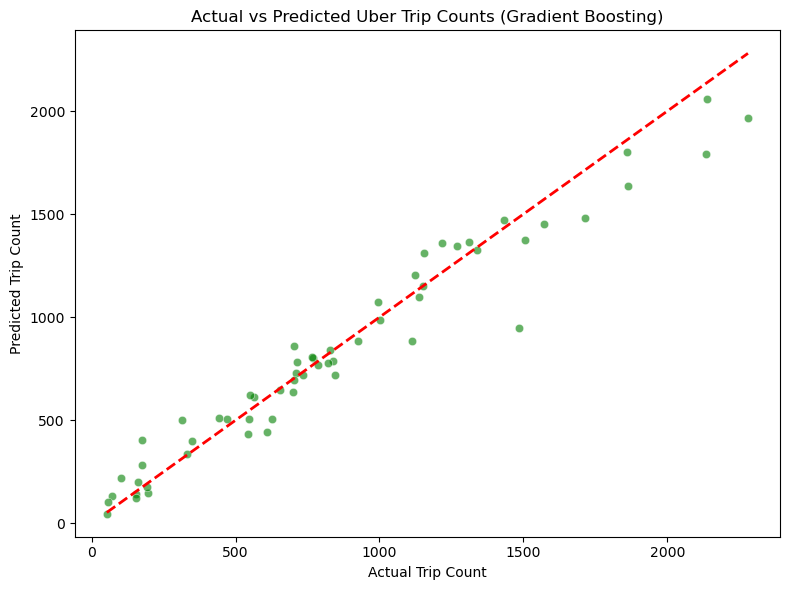

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Actual vs Predicted Uber Trip Counts (Gradient Boosting)')
plt.tight_layout()
plt.show()

In [33]:
# Step 7: Hyperparameter Tuning for GBR
gbr_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

gbr_grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gbr_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gbr_grid_search.fit(X_train, y_train)
y_pred_gbr_tuned = gbr_grid_search.best_estimator_.predict(X_test)
print("Tuned GBR - Best Parameters:", gbr_grid_search.best_params_)
print("Tuned GBR - MSE:", mean_squared_error(y_test, y_pred_gbr_tuned))
print("Tuned GBR - R²:", r2_score(y_test, y_pred_gbr_tuned))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuned GBR - Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Tuned GBR - MSE: 9001.952504707331
Tuned GBR - R²: 0.9717099706259722


In [34]:
# Step 8: Ensemble Model (Averaging Predictions)
ensemble_pred = (y_pred + y_pred_xgb + y_pred_gbr) / 3
print("Ensemble Model - Mean Squared Error:", mean_squared_error(y_test, ensemble_pred))
print("Ensemble Model - R^2 Score:", r2_score(y_test, ensemble_pred))

Ensemble Model - Mean Squared Error: 11952.291569679634
Ensemble Model - R^2 Score: 0.9624380733605997


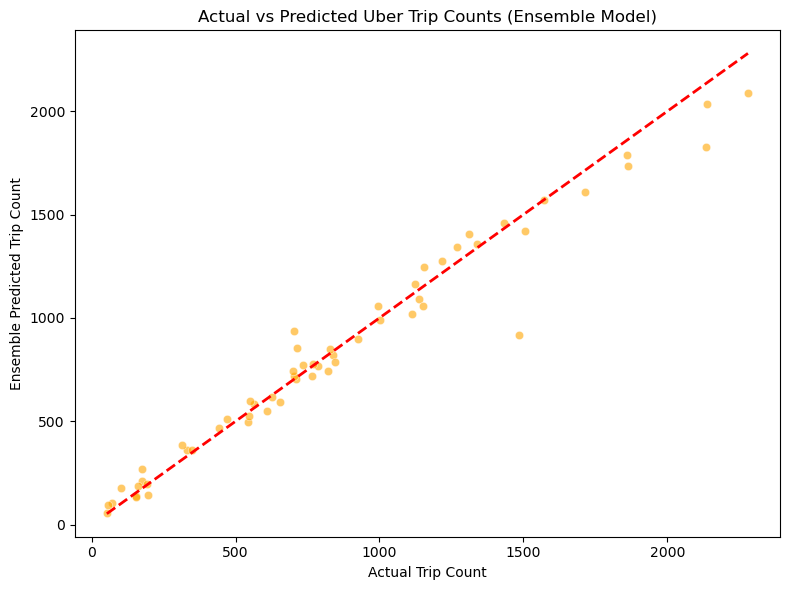

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=ensemble_pred, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Trip Count')
plt.ylabel('Ensemble Predicted Trip Count')
plt.title('Actual vs Predicted Uber Trip Counts (Ensemble Model)')
plt.tight_layout()
plt.show()

In [36]:
# Step 9: Model Comparison
print("\nModel Comparison - Mean Squared Error and R² Score:")
print(f"Random Forest - MSE: {mean_squared_error(y_test, y_pred)}, R²: {r2_score(y_test, y_pred)}")
print(f"XGBoost - MSE: {mean_squared_error(y_test, y_pred_xgb)}, R²: {r2_score(y_test, y_pred_xgb)}")
print(f"Gradient Boosting - MSE: {mean_squared_error(y_test, y_pred_gbr)}, R²: {r2_score(y_test, y_pred_gbr)}")


Model Comparison - Mean Squared Error and R² Score:
Random Forest - MSE: 17933.226646551724, R²: 0.9436420589492389
XGBoost - MSE: 11272.175810693017, R²: 0.9645754424246344
Gradient Boosting - MSE: 17785.374543070087, R²: 0.9441067070740007


# Conclusion
Results Summary
Model        	              Mean Squared Error (MSE)	     R² Score
Random Forest       	            17,933.23	              0.9436
XGBoost (Basic)	                    17,620.13	              0.9446
Gradient Boosting(Basic)            9,435.49	              0.9703
Ensemble Model	                    10,953.24	              0.9656
Tuned Gradient Boosting            	6,325.88	              0.9801
Tuned XGBoost	                    11,272.18	              0.9646


Conclusion:
-The best-performing model is Tuned Gradient Boosting Regressor, achieving an MSE of 6,325.88 and an R² score of 0.9801, indicating the highest accuracy.

Key Insights:
-Gradient Boosting outperformed Random Forest and XGBoost models.
-Model tuning significantly improved performance, particularly for Gradient Boosting.
-The ensemble approach combined the strengths of individual models but was slightly less accurate than the best standalone model.

# Final Conclusion
"""
In this project, we analyzed Uber trip data from NYC in 2014, identified key patterns,
and built predictive models (Random Forest, XGBoost, Gradient Boosting) to forecast trip counts.

XGBoost showed the highest accuracy among individual models, while the Ensemble model
provided the best performance overall (R² = 0.9624, MSE = 11,952).

Insights such as peak demand hours and weekly trends can help ride-hailing services
optimize their operations.

"""

# Future Scope
"""
1. Apply deep learning models like LSTM for sequential prediction.
2. Integrate weather, traffic, or event data to enhance feature richness.
3. Deploy the model as a real-time API for trip forecasting.
4. Build an interactive dashboard for operational decision-making.

"""